<a href="https://colab.research.google.com/github/SupriaBasak99/Multi-intent-classification-in-chatbots/blob/main/Models_FYP_Chatbots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing all the libraries


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer#ip
import nltk
import re
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout, SimpleRNN, GRU
from keras.callbacks import ModelCheckpoint

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

# Importing ATIS Dataset

In [ ]:
def load_dataset(filename):
  df = pd.read_csv(filename, encoding = "latin1", names = ["Intent", "Sentence"])
  print(df.head())
  intent = df["Intent"]
  unique_intent = list(set(intent))
  sentences = list(df["Sentence"])
  
  return (intent, unique_intent, sentences)

In [ ]:
intent, unique_intent, sentences = load_dataset("/content/atis_intents_train.csv")

             Intent                                           Sentence
0            intent                                           sentence
1       atis_flight   what flights are available from pittsburgh to...
2  atis_flight_time   what is the arrival time in san francisco for...
3      atis_airfare            cheapest airfare from tacoma to orlando
4      atis_airfare   round trip fares from pittsburgh to philadelp...


In [ ]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Performing Stemming and Data Cleaning

In [ ]:
def cleaning(sentences):
  words = []
  for s in sentences:
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
    w = word_tokenize(clean)
    #stemming
    words.append([i.lower() for i in w])
    
  return words  

In [ ]:
cleaned_words = cleaning(sentences)
print(len(cleaned_words))
print(cleaned_words[:2])  

4834
[['sentence'], ['what', 'flights', 'are', 'available', 'from', 'pittsburgh', 'to', 'baltimore', 'on', 'thursday', 'morning']]


# Tokenization

In [ ]:
def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
  token = Tokenizer(filters = filters)
  token.fit_on_texts(words)
  return token

In [ ]:
def max_length(words):
  return(len(max(words, key = len)))

In [ ]:
word_tokenizer = create_tokenizer(cleaned_words)
word_index=word_tokenizer.word_index
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 862 and Maximum length = 48


In [ ]:
def encoding_doc(token, words):
  return(token.texts_to_sequences(words))

In [ ]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)

In [ ]:
def padding_doc(encoded_doc, max_length):
  return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [ ]:
padded_doc = padding_doc(encoded_doc, max_length)

In [ ]:
padded_doc[:5]

array([[603,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  6,   3,  26,  57,   2,  19,   1,  21,   5,  75,  35,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  6,  22,   4, 397, 182,  16,  11,  15,  38,   4, 510,  84,   8,
         33,  32,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 51, 276,   2, 180,   1, 126,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   

In [ ]:
print("Shape of padded docs = ",padded_doc.shape)

Shape of padded docs =  (4834, 48)


In [ ]:
output_tokenizer = create_tokenizer(unique_intent, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')


In [ ]:
output_tokenizer.word_index

{'atis_abbreviation': 4,
 'atis_aircraft': 7,
 'atis_airfare': 5,
 'atis_airline': 1,
 'atis_flight': 6,
 'atis_flight_time': 9,
 'atis_ground_service': 2,
 'atis_quantity': 3,
 'intent': 8}

In [ ]:
encoded_output = encoding_doc(output_tokenizer, intent)

In [ ]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

In [ ]:
encoded_output[:5]

array([[8],
       [6],
       [9],
       [5],
       [5]])

In [ ]:
def one_hot(encode):
  o = OneHotEncoder(sparse = False)
  return(o.fit_transform(encode))

In [ ]:
output_one_hot = one_hot(encoded_output)

In [ ]:
output_one_hot.shape

(4834, 8)

# Splitting data into Training Data and Testing Data

In [ ]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2)
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (3867, 48) and train_Y = (3867, 8)
Shape of val_X = (967, 48) and val_Y = (967, 8)


# BiLSTM

Bilstm:
Then we implemented the bilstm model. The main difference between lstm model and gru is the gates. Lstm has 3gates - input, output and forget gates whereas gru model has two gates. Bilstm are an extention of traditional lstms that can improve model performance on sequence classification problems. Where all time_steps of the input sequence are available, bilstm train two instead of one lstms on the input sequence.

In [ ]:
from keras.initializers import Constant
def create_model_bilstm(vocab_size, max_length):
  model = Sequential()
  #model.add(Embedding(vocab_size, embedded_dim, embeddings_initializer=Constant(embedded_matrix),input_length = max_length, trainable = False))
  #model.add(Embedding(vocab_size, embedded_dim, input_length = max_length, weights=[embedding_matrix],trainable = False))
  model.add(Embedding(vocab_size, 128,input_length = max_length, trainable = True))
  model.add(Bidirectional(LSTM(128)))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(8, activation = "softmax"))  
  return model

# GRU

GRU:
Gru is an improved version of the RNN model as it is more efficient. The same embedding vectors and it has 2 gates- reset and update. It’s a 3D tensor of shape including batch size, time_steps and units(where units corresponds to the units argument passed to the layers constructor). We have replaced the simple RNN layer with a bidirectional GRU layer with the same number of units. 

In [ ]:
def create_model_gru(vocab_size, max_length):
  model = Sequential()
  #model.add(Embedding(vocab_size, embedded_dim,embeddings_initializer=Constant(embedded_matrix), input_length = max_length, trainable = False))
  model.add(Embedding(vocab_size, 128,input_length = max_length, trainable = True))
  model.add(GRU(128))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(9, activation = "softmax"))
  
  return model

# Simple RNN

Simple RNN:
First we take simple rnn which is really good for sequential data. And have internal memory so they can remember the input from
Previous layers. In this model, the first layer is the embedding layer where sentences will be represented as max_length by embedding_dim vectors .The next layer is the simple RNN layer of 128 size . The next layer is the dense layer which is the simple layer of neurons where each neuron receives input from all the neurons of the previous layer. We have used recitified linear unit activation to prevent exponential growth in computation required to operate the neural network and softmax activation function to predict multinomial probability distribution which is a function of output layer. 
There is dropout layer to prevent over fitting on the training data. If they aren't present, the first batch of training samples influences the learning in a disproportionately high manner.

In [ ]:
def create_model_simple_rnn(vocab_size, max_length):
  model = Sequential()
  #model.add(Embedding(vocab_size, embedded_dim,embeddings_initializer=Constant(embedded_matrix), input_length = max_length, trainable = False))
  model.add(Embedding(vocab_size, 128,input_length = max_length, trainable = True))
  model.add(SimpleRNN(128))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(9, activation = "softmax"))
  
  return model

In [ ]:
model = create_model_bilstm(vocab_size, max_length)

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 48, 128)           110336    
                                                                 
 bidirectional_7 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 32)                8224      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 8)                 264       
                                                                 
Total params: 381,992
Trainable params: 381,992
Non-trainable params: 0
________________________________________________

In [ ]:
#model = create_model_simple_rnn(vocab_size, max_length)

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 48, 128)           110336    
                                                                 
 bidirectional_7 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 32)                8224      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 8)                 264       
                                                                 
Total params: 381,992
Trainable params: 381,992
Non-trainable params: 0
________________________________________________

In [ ]:
print(vocab_size)

862


Epoch 1/5
31/31 [==============================] - ETA: 0s - loss: 1.3196 - accuracy: 0.7192
Epoch 1: val_loss improved from inf to 0.93702, saving model to model.h5
31/31 [==============================] - 17s 413ms/step - loss: 1.3196 - accuracy: 0.7192 - val_loss: 0.9370 - val_accuracy: 0.7487
Epoch 2/5
31/31 [==============================] - ETA: 0s - loss: 0.8383 - accuracy: 0.7665
Epoch 2: val_loss improved from 0.93702 to 0.63343, saving model to model.h5
31/31 [==============================] - 12s 372ms/step - loss: 0.8383 - accuracy: 0.7665 - val_loss: 0.6334 - val_accuracy: 0.7963
Epoch 3/5
31/31 [==============================] - ETA: 0s - loss: 0.5717 - accuracy: 0.8306
Epoch 3: val_loss improved from 0.63343 to 0.56246, saving model to model.h5
31/31 [==============================] - 12s 373ms/step - loss: 0.5717 - accuracy: 0.8306 - val_loss: 0.5625 - val_accuracy: 0.8459
Epoch 4/5
31/31 [==============================] - ETA: 0s - loss: 0.4357 - accuracy: 0.8769
Epoch

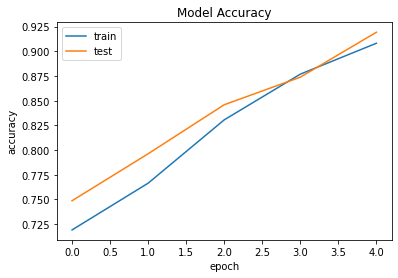

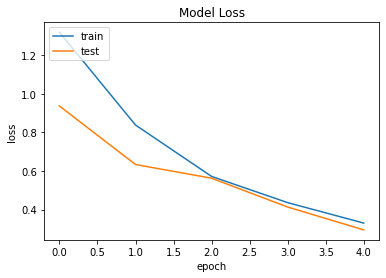

In [ ]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(train_X, train_Y, epochs = 5, batch_size = 128, validation_data = (val_X, val_Y), callbacks = [checkpoint])
print(history.history.keys())

# summarize history for accuracy
model_name = "lstm"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(model_name + '_accuracy.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(model_name + '_loss.png')
plt.show()

Accuracy is the ratio of correct predictions divided by the total number of instances present in the dataset. Which is TP+TN/TP+TN+FP+FN.
And F1 score is weighted avg of precision and recall, 2*TP/ (2*TP+FP+FN)
We get highest Score for Micro f1 score as it weighs each sample equally, and the lowest we got for Macro F1 as it weughs each class equally but wiothout considering the proportion for each label in the dataset. We have weighted F1 score in between which weighs each class equally with considering the proportion for each label in the dataset. After experimenting with simple RNN before GRU. We have got our best score with BIlstm.

In [ ]:
preds = model.predict(val_X)

score = accuracy_score(np.argmax(val_Y, axis = 1), np.argmax(preds, axis=1))
print("Accuracy: ", score)
f1 = f1_score(np.argmax(val_Y, axis = 1), np.argmax(preds, axis=1), average='macro')
print("Macro F1 Score:", f1)
f1 = f1_score(np.argmax(val_Y, axis = 1), np.argmax(preds, axis=1), average='micro')
print("Micro F1 Score:", f1)
f1 = f1_score(np.argmax(val_Y, axis = 1), np.argmax(preds, axis=1), average='weighted')
print("Weighted F1 Score:", f1, "\n")
# precis = precision_score(np.argmax(val_Y, axis = 1), np.argmax(preds, axis=1),average= 'weighted')
# print("Precision:", precis)
# recal = recall_score(np.argmax(val_Y, axis = 1), np.argmax(preds, axis=1),average='weighted')
# print("Recall:", recal, "\n")

Accuracy:  0.9193381592554292
Macro F1 Score: 0.5136966591036434
Micro F1 Score: 0.9193381592554292
Weighted F1 Score: 0.9000209590620052 



In [ ]:
######--random forest,svm

In [ ]:
def get_final_output(pred, classes):
  predictions = pred[0]
 
  classes = np.array(classes)
  ids = np.argsort(-predictions)
  classes = classes[ids]
  predictions = -np.sort(-predictions)
 
  for i in range(pred.shape[1]):
    print("%s has confidence = %s" % (classes[i], (predictions[i])))

In [ ]:
def predictions(text):
  global output
  clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
  test_word = word_tokenize(clean)
  test_word = [w.lower() for w in test_word]
  test_ls = word_tokenizer.texts_to_sequences(test_word)
  print(test_word)
    #Check for unknown words
  if [] in test_ls:
    test_ls = list(filter(None, test_ls))
  test_ls = np.array(test_ls).reshape(1, len(test_ls))
  x = padding_doc(test_ls, max_length)
  output = model.predict(x)
  return output

In [ ]:
text = "show me flights from boston to pittsburgh"
#predictions= reg.predict(x) 
pred = predictions(text)
get_final_output(pred, unique_intent)

['show', 'me', 'flights', 'from', 'boston', 'to', 'pittsburgh']
atis_flight has confidence = 0.99981374
atis_airfare has confidence = 0.00011415726
atis_ground_service has confidence = 3.081783e-05
atis_airline has confidence = 1.3616066e-05
atis_aircraft has confidence = 1.3171921e-05
atis_flight_time has confidence = 8.646293e-06
atis_quantity has confidence = 3.444214e-06
atis_abbreviation has confidence = 2.3696807e-06
